In [2]:
import cv2
import pytesseract
import pandas as pd
import matplotlib.pyplot as plt
import requests
from IPython.display import Image
import os
import json

This tutorial is based on: 
* OpenCV for image processing
* Tesseract OCR for extracting text from images
* Pandas for structuring data 

Images are taken from: 
* https://www.mattmahoney.net/ocr
* https://keras.io/examples/vision/autoencoder
* https://cran.r-project.org/web/packages/tesseract/vignettes/intro.html

#### Download images

In [49]:
image_paths = []
image_urls = [
    'https://www.mattmahoney.net/ocr/stock_gs200.jpg', 
    'https://www.mattmahoney.net/ocr/plaid_c150.jpg',
    'https://www.mattmahoney.net/ocr/captcha1.jpg',
    'https://www.mattmahoney.net/ocr/numbers_gs150.jpg',
    'https://i.sstatic.net/6VfvN.png',
    'https://jeroen.github.io/images/bowers.jpg',
    'https://jeroen.github.io/images/testocr.png',
    'https://jeroen.github.io/images/receipt.png'
]

directory = os.path.join(".", "data", "3_04")
if not os.path.exists(directory):
    os.makedirs(directory)
    
for i, url in enumerate(image_urls):
    data = requests.get(url).content
    name = f"ocr_sample{i}.{url.split('.')[-1]}" 
    path = os.path.join(directory, name)
    
    with open(path, 'wb') as f:
        f.write(data)
        image_paths.append(path)

#### Pick a test sample image

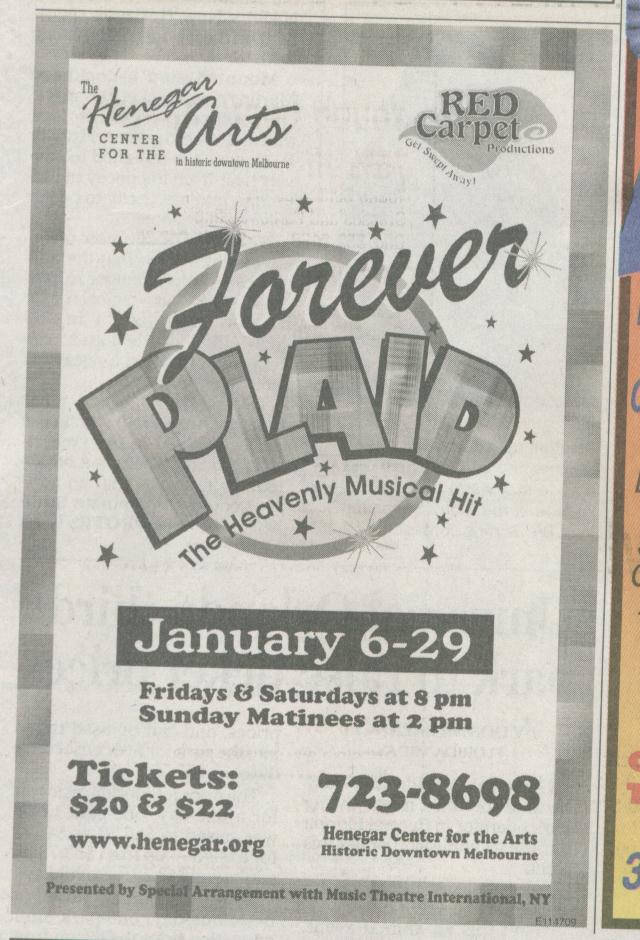

In [61]:
image_file = image_paths[1]
Image(filename=image_file)

#### Load and preprocess image

In [91]:
# Read image from a file and load it in the form of a NumPy array
image = cv2.imread(image_file)

# Convert the image to grayscale
processed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

# Reduce noise (optional)
# processed_image = cv2.GaussianBlur(processed_image, (1, 1), 0) 

#### Add a function for displaying processed image and extracted text

In [92]:
def display_image_text(image, threshold, text):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image in the first column
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"Threshold Value: {threshold}")
    axes[0].axis('off')  

    # Display the extracted text in the second column
    axes[1].text(0.1, 0.8, text, fontsize=10, wrap=True, verticalalignment='top')
    axes[1].set_title("Extracted Text")
    axes[1].axis('off')  
  
    plt.tight_layout() 
    plt.show()

#### Extract text with pytesseract

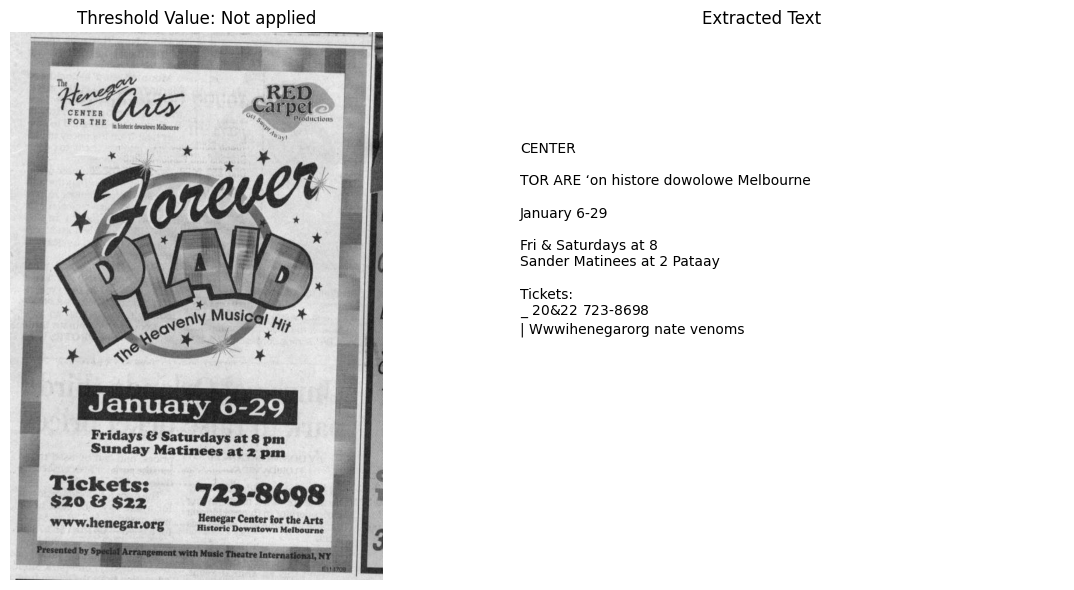

In [93]:
extracted_text = pytesseract.image_to_string(processed_image)

display_image_text(processed_image, "Not applied", extracted_text)

#### Apply thresholding to enhance the text before extracting

##### Var 1: Convert the grayscale image into a binary image, applying a threshold value of 125

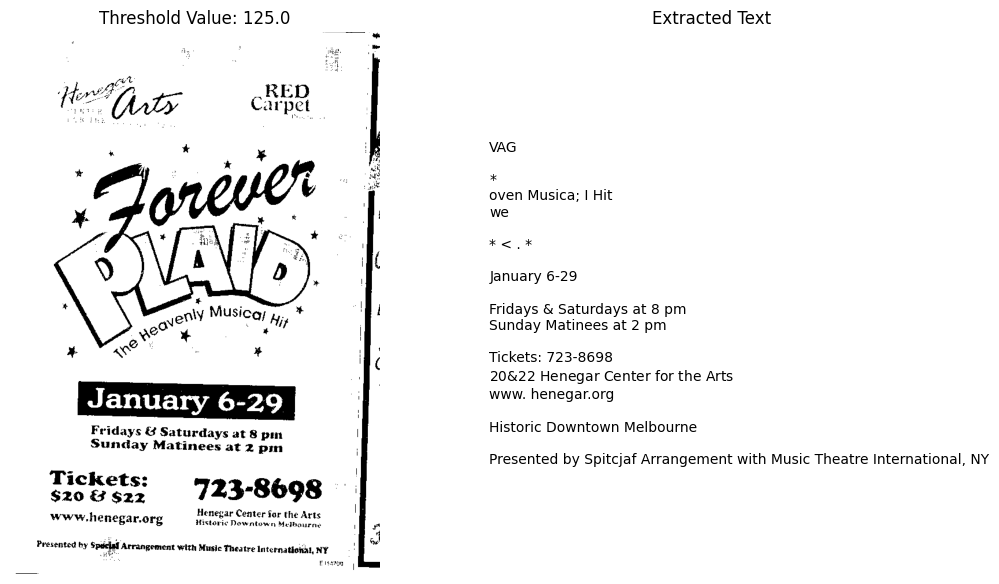

In [94]:
# Any pixel with an intensity greater than or equal to 125 will be set to the maximum value of 255 
threshold_value, threshold_image1 = cv2.threshold(processed_image, 125, 255, cv2.THRESH_BINARY) 
 
extracted_text = pytesseract.image_to_string(threshold_image1)

display_image_text(threshold_image1, threshold_value, extracted_text)

##### Var 2: Apply Otsu's thresholding method

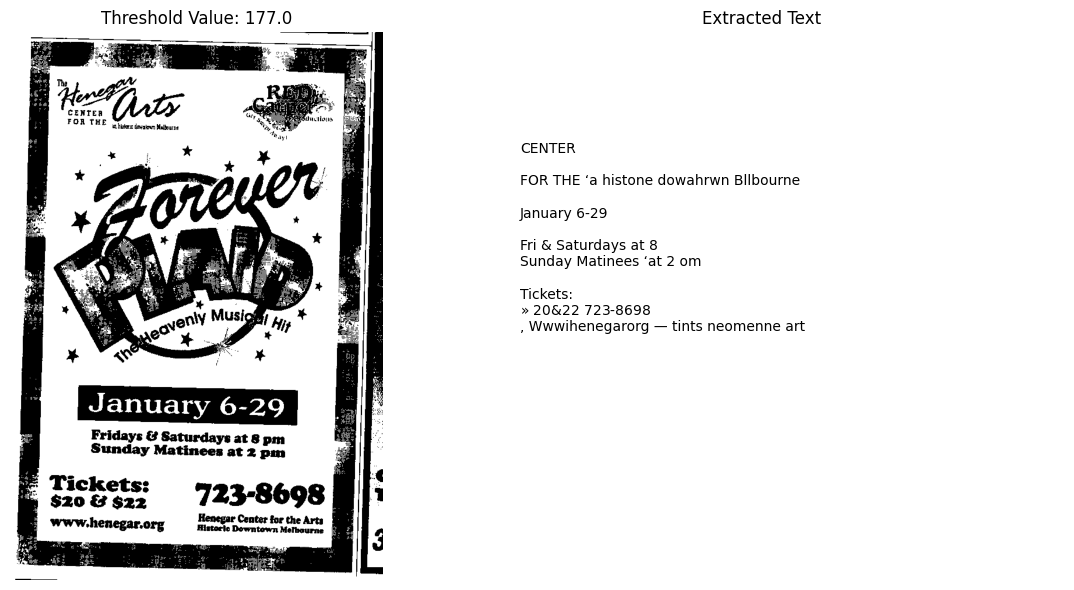

In [95]:
# cv2.THRESH_OTSU does not require a predefined threshold, OpenCV computes the best threshold for separating foreground from background automatically
# threshold_value, threshold_image2 = cv2.threshold(processed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
threshold_value, threshold_image2 = cv2.threshold(processed_image, 0, 255, cv2.THRESH_OTSU) 
 
extracted_text = pytesseract.image_to_string(threshold_image2)

display_image_text(threshold_image2, threshold_value, extracted_text)

##### Var 3: Calculate threshold value for each pixel based on the weighted sum of the neighborhood pixel values

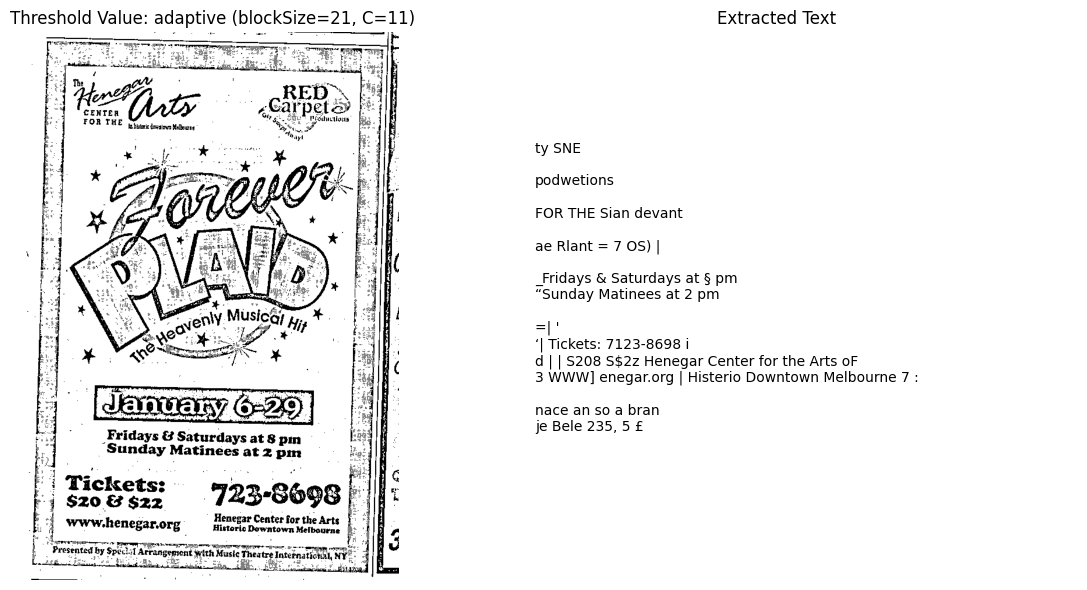

In [97]:
# Calculates different thresholds for different regions of the image, which can be useful for unevenly lit images.
# This method can also be used if the image has varying lighting conditions
blocksize = 21
C = 11
threshold_image3 = cv2.adaptiveThreshold(processed_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, C)

# ADAPTIVE_THRESH_GAUSSIAN_C calculates the threshold value for each pixel based on the weighted sum of the neighborhood pixel values, 
# where the weights are determined by a Gaussian window. It takes into account local variations in brightness and contrast.

# blocksize is the size of the local neighborhood: a square region ("window") around each pixel used to calculate the threshold value for each pixel.  
# It should be an odd integer (e.g., 3, 5, 7, 11, etc.).   
# Larger window is useful for images with more complex lighting variations, but may blur fine details in the image.

# C is a parameter that fine-tunes the threshold - it is subtracted from the computed threshold to control how aggressive the thresholding is.
# Larger value results in more pixels being set to 0 (black), smaller value makes the threshold more lenient, keeping more pixels white (255).

# An alternative method to use is cv2.ADAPTIVE_THRESH_MEAN_C, which uses the mean of the neighborhood pixel values rather than a weighted sum. 
# The Gaussian method usually produces better results when dealing with images that have non-uniform lighting.

extracted_text = pytesseract.image_to_string(threshold_image3)

display_image_text(threshold_image3, f"adaptive (blockSize={blocksize}, C={C})", extracted_text)

#### Extract individual words and bounding boxes by using image_to_data

In [117]:
# Extract text with data (including position, confidence, etc.)
detection_data = pytesseract.image_to_data(threshold_image1, output_type=pytesseract.Output.DICT)

# Pretty-print detection data
df = pd.DataFrame(detection_data) 
detected_words = df[df['text'].notnull() & (df['text'].str.len() > 1)]
detected_words

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
8,5,1,2,1,1,1,76,219,455,330,95,
12,5,1,3,1,1,1,213,336,295,154,0,VAG
18,5,1,4,1,2,1,257,481,78,58,44,oven
19,5,1,4,1,2,2,346,471,96,45,78,Musica;
21,5,1,4,1,2,4,452,489,29,26,63,Hit
23,5,1,4,1,3,1,223,512,33,31,57,we
34,5,1,6,1,1,1,134,617,211,48,96,January
35,5,1,6,1,1,2,360,624,112,38,96,6-29
39,5,1,7,1,1,1,141,683,86,21,93,Fridays
41,5,1,7,1,1,3,260,686,117,22,96,Saturdays


#### Visualize bounding boxes of extracted words

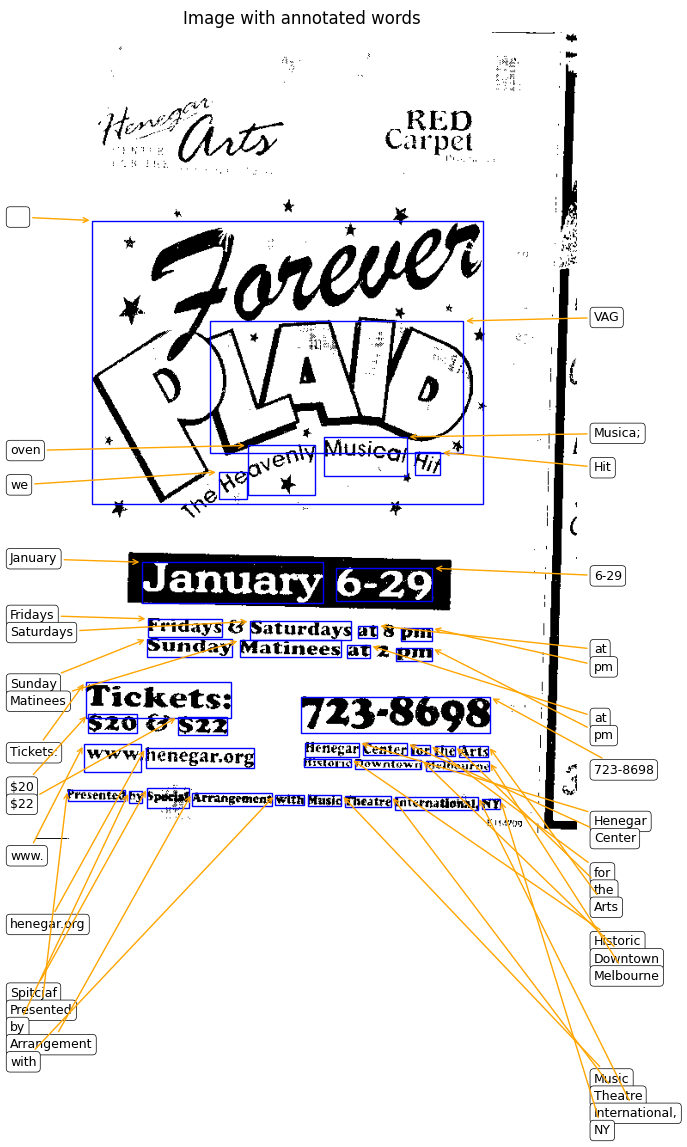

In [292]:
bb_image = cv2.cvtColor(threshold_image1, cv2.COLOR_GRAY2BGR)   

plt.figure(figsize=(10, 12))
plt.imshow(bb_image)
plt.axis('off')
plt.title("Image with annotated words")

image_width = bb_image.shape[1]
# Horizontal midpoint of the image
midline_x = image_width // 2
# Init annotation text positioning 
left_text_x = -20  # Left horizontal position 
right_text_x = image_width + 20  # Right horizontal position
last_text_y = 0  # Initial vertical position
text_spacing_y = 20 # Vertical spacing
 
for row in detected_words.sort_values(by='top').itertuples():
    # Extract bounding box params
    x, y, w, h = row.left, row.top, row.width, row.height
    text = row.text

    # plt.gca() returns the current axes object to plot on
    # add_patch(...) adds a shape or object to the plot
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', linewidth=1))

    # Determine text placement of annotation text around the image 
    left_side = (x + w // 2 < midline_x) # True = Left, Flase = Right
    # Position the text on the right or left side of image
    text_x = left_text_x if left_side else right_text_x  
    # Position the arrow on the right or left edge of the bounding box
    arrow_x = x if left_side else x + w  
    # Determine the vertical position for the text to avoid overlap
    text_overlap = (y - last_text_y <= text_spacing_y) and i # True = add more spacing 
    text_y = text_y + text_spacing_y if text_overlap else y 
    # Update the last vertical position
    last_text_y = text_y
 
    # Draw the word with an arrow pointing to the bounding box
    plt.annotate(
        text,
        xy=(arrow_x, y),         
        xytext=(text_x, text_y),  
        arrowprops=dict(arrowstyle="->", color='orange'),
        fontsize=9,
        color='black',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
    ) 
    
plt.tight_layout()
plt.show()

#### Save extracted information in structured format

In [114]:
# Organize the extracted information into a structured format like CSV or JSON 

# Save the result as JSON file
df.to_json(os.path.join(directory, 'output.json'), orient='records', lines=True) 
print(df.to_json(orient='records', lines=True))

# Save the result as CSV file
df.to_csv(os.path.join(directory, 'output.csv'), index=False) 

{"level":1,"page_num":1,"block_num":0,"par_num":0,"line_num":0,"word_num":0,"left":0,"top":0,"width":640,"height":940,"conf":-1,"text":""}
{"level":2,"page_num":1,"block_num":1,"par_num":0,"line_num":0,"word_num":0,"left":545,"top":0,"width":69,"height":3,"conf":-1,"text":""}
{"level":3,"page_num":1,"block_num":1,"par_num":1,"line_num":0,"word_num":0,"left":545,"top":0,"width":69,"height":3,"conf":-1,"text":""}
{"level":4,"page_num":1,"block_num":1,"par_num":1,"line_num":1,"word_num":0,"left":545,"top":0,"width":69,"height":3,"conf":-1,"text":""}
{"level":5,"page_num":1,"block_num":1,"par_num":1,"line_num":1,"word_num":1,"left":545,"top":0,"width":69,"height":3,"conf":95,"text":" "}
{"level":2,"page_num":1,"block_num":2,"par_num":0,"line_num":0,"word_num":0,"left":76,"top":219,"width":455,"height":330,"conf":-1,"text":""}
{"level":3,"page_num":1,"block_num":2,"par_num":1,"line_num":0,"word_num":0,"left":76,"top":219,"width":455,"height":330,"conf":-1,"text":""}
{"level":4,"page_num":1,